<div><a href="https://knodis-research-group.github.io/"><img style="float: right; width: 128px; vertical-align:middle" src="https://knodis-research-group.github.io/knodis-logo_horizontal.png" alt="KNODIS logo" /></a>

# Comparación de rendimiento de modelos<a id="top"></a>

<i><small>Última actualización: 2025-03-15</small></i></div>
***

## Enunciado

Compara el rendimiento de tres modelos de redes neuronales para clasificar el conjunto de datos MNIST:

1. Un modelo sin capas ocultas,
2. Un modelo con $1$ capa oculta sin función de activación ($\implies$ activación lineal),
3. Un modelo con $1$ capa oculta con una activación tangente hiperbólica tras la capa oculta, y
4. Un modelo con $1$ capa oculta con una activación _leaky_ ReLU tras la capa oculta.

Entrena cada uno de los modelos con el conjunto de entrenamiento de [**KMNIST**](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST) y evalúa su rendimiento en el conjunto de prueba utilizando la exactitud (_accuracy_) de clasificación.

***

## Bibliotecas

In [1]:
import time

import pandas as pd
import torch
import torchvision

Constantes, configuración y demás

In [2]:
DATASETS_DIR = 'tmp'
BATCH_SIZE = 128

## Carga y preparación de datos

In [3]:
train_dataset = torchvision.datasets.KMNIST(
    root=DATASETS_DIR,
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_dataset = torchvision.datasets.KMNIST(
    root=DATASETS_DIR,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [4]:
N_CLASSES = len(train_dataset.classes)

## Creación de los modelos

### 1. Modelo sin capas ocultas

In [5]:
model1 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(out_features=N_CLASSES),
)
print(model1)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LazyLinear(in_features=0, out_features=10, bias=True)
)


### 2. Modelo con capas ocultas de activación lineal

In [6]:
model2 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(out_features=32),
    torch.nn.LazyLinear(out_features=N_CLASSES),
)
print(model2)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LazyLinear(in_features=0, out_features=32, bias=True)
  (2): LazyLinear(in_features=0, out_features=10, bias=True)
)


### 3. Modelo con capas ocultas con activación de tipo tangente hiperbólica

In [7]:
model3 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(out_features=32),
    torch.nn.Tanh(),
    torch.nn.LazyLinear(out_features=N_CLASSES),
)
print(model3)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LazyLinear(in_features=0, out_features=32, bias=True)
  (2): Tanh()
  (3): LazyLinear(in_features=0, out_features=10, bias=True)
)


### 4. Modelo con capas ocultas con activación de tipo LeakyReLU

In [8]:
model4 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(out_features=32),
    torch.nn.LeakyReLU(negative_slope=0.1),
    torch.nn.LazyLinear(out_features=N_CLASSES),
)
print(model4)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LazyLinear(in_features=0, out_features=32, bias=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): LazyLinear(in_features=0, out_features=10, bias=True)
)


## Entrenamiento de los modelos

In [9]:
def train_model(model, train_loader, test_loader, n_epochs, criterion=None, optimizer=None):
    criterion = criterion or torch.nn.CrossEntropyLoss()
    optimizer = optimizer or torch.optim.Adam(model.parameters())

    train_losses = []
    train_accuracy = []
    train_times = []
    test_accuracy = []
    for epoch in range(n_epochs):
        # ENTRENAMIENTO
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        start_time = time.time()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        epoch_time = time.time() - start_time
        
        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_acc)
        train_times.append(epoch_time)

        # EVALUACIÓN
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_test_acc = correct / total

        test_accuracy.append(epoch_test_acc)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Accuracy (test): {epoch_test_acc:.4f}, Time (s.): {epoch_time:.4f}")

    return {
        'Train losses': train_losses,
        'Train accuracies': train_accuracy,
        'Train times': train_times,
        'Test accuracies': test_accuracy,
    }

In [10]:
N_EPOCHS = 100

print("Model 1")
history1 = train_model(model1, train_loader, test_loader, N_EPOCHS)
print("Model 2")
history2 = train_model(model2, train_loader, test_loader, N_EPOCHS)
print("Model 3")
history3 = train_model(model3, train_loader, test_loader, N_EPOCHS)
print("Model 4")
history4 = train_model(model4, train_loader, test_loader, N_EPOCHS)

Model 1


/home/blazaid/Projects/aprendizaje-profundo/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 10 - Loss: 72.0857, Accuracy: 0.8347, Accuracy (test): 0.8154, Time (s.): 3.6396
Epoch 20 - Loss: 69.9928, Accuracy: 0.8383, Accuracy (test): 0.8186, Time (s.): 3.6681
Epoch 30 - Loss: 69.0938, Accuracy: 0.8395, Accuracy (test): 0.8197, Time (s.): 3.6890
Epoch 40 - Loss: 68.4479, Accuracy: 0.8413, Accuracy (test): 0.8213, Time (s.): 3.6333
Epoch 50 - Loss: 68.0547, Accuracy: 0.8427, Accuracy (test): 0.8225, Time (s.): 3.7999
Epoch 60 - Loss: 67.7616, Accuracy: 0.8421, Accuracy (test): 0.8217, Time (s.): 3.8023
Epoch 70 - Loss: 67.6100, Accuracy: 0.8428, Accuracy (test): 0.8220, Time (s.): 3.6813
Epoch 80 - Loss: 67.3602, Accuracy: 0.8429, Accuracy (test): 0.8220, Time (s.): 3.6316
Epoch 90 - Loss: 67.1299, Accuracy: 0.8440, Accuracy (test): 0.8222, Time (s.): 3.7402
Epoch 100 - Loss: 67.1248, Accuracy: 0.8428, Accuracy (test): 0.8219, Time (s.): 3.6021
Model 2
Epoch 10 - Loss: 71.6704, Accuracy: 0.8339, Accuracy (test): 0.8139, Time (s.): 3.6215
Epoch 20 - Loss: 70.4189, Accuracy

NameError: name 'plt' is not defined

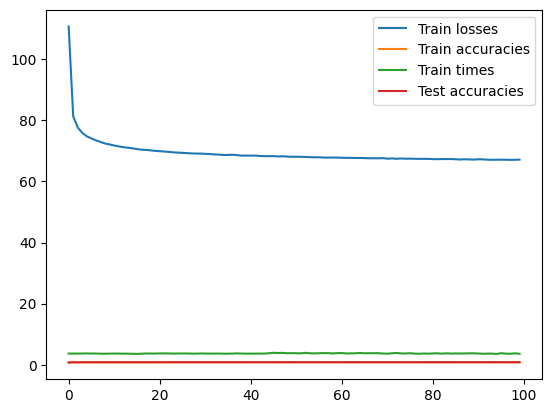

In [11]:
pd.DataFrame(history1).plot()
plt.xlabel('Epoch num.')
plt.yscale('log')
plt.show()

In [ ]:
pd.DataFrame(history2).plot()
plt.xlabel('Epoch num.')
plt.yscale('log')
plt.show()

In [ ]:
pd.DataFrame(history3).plot()
plt.xlabel('Epoch num.')
plt.yscale('log')
plt.show()

In [ ]:
pd.DataFrame(history4).plot()
plt.xlabel('Epoch num.')
plt.yscale('log')
plt.show()

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Back to top](#top)

</div>